In [1]:
%matplotlib inline

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.models.rnn import rnn, rnn_cell

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)



Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
'''
NOTE: These parameters are ajusted for a very fast training stage
 if you have a cuda-enabled GPU and free time you can try to tune 
 them to optain an optimal performance
'''

# Network Parameters
n_input = 28 # MNIST data input (img shape: 28*28)
n_steps = 15 # timesteps
n_hidden = 150 # hidden layer num of features
n_classes = 28 # MNIST total classes (0-9 digits)


# Parameters
learning_rate = 0.0005
training_iters = 10000000
display_step = 150

batch_size = 150*(27-n_steps)

In [3]:
# tf Graph input
x = tf.placeholder("float", [None, n_steps, n_input])
istate = tf.placeholder("float", [None, 2*n_hidden]) #state & cell => 2x n_hidden
y = tf.placeholder("float", [None, n_classes])

# Define weights
weights = {
    'hidden': tf.Variable(tf.random_normal([n_input, n_hidden])), # Hidden layer weights
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes]))
}
biases = {
    'hidden': tf.Variable(tf.random_normal([n_hidden])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

In [4]:
def RNN(_X, _istate, _weights, _biases):

    # input shape: (batch_size, n_steps, n_input)
    _X = tf.transpose(_X, [1, 0, 2])  # permute n_steps and batch_size
    # Reshape to prepare input to hidden activation
    _X = tf.reshape(_X, [-1, n_input]) # (n_steps*batch_size, n_input)
    # Linear activation
    _X = tf.matmul(_X, _weights['hidden']) + _biases['hidden']

    # Define a lstm cell with tensorflow
    lstm_cell = rnn_cell.BasicLSTMCell(n_hidden, forget_bias=1.0)
    # Split data because rnn cell needs a list of inputs for the RNN inner loop
    _X = tf.split(0, n_steps, _X) # n_steps * (batch_size, n_hidden)

    # Get lstm cell output
    outputs, states = rnn.rnn(lstm_cell, _X, initial_state=_istate)

    # Get inner loop last output
    return tf.nn.sigmoid(tf.matmul(outputs[-1], _weights['out']) + _biases['out'])

In [5]:
pred = RNN(x, istate, weights, biases)

# Define loss and optimizer
cost = tf.reduce_mean(tf.square(pred-y)) # MSE loss
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [6]:
''' 
 This function creates several training sequences from each
 MNIST sample image, each training sequence consists of #n_steps samples
 with 28 features.
'''

def sequencesFromTrainingData(data, nSteps):
    
    X = []
    Y = []
    
    for sample in data:
        sample = sample.reshape((28,28))
        for i in range(27-nSteps):
            X.append(sample[i:i+nSteps,:])
            Y.append(sample[i+nSteps][:])
    return np.asarray(X), np.asarray(Y)
        


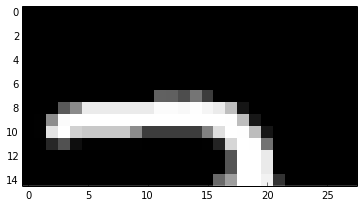

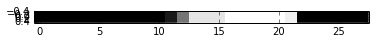

In [7]:
'''
This Cell shows a sample sequence and the trarget
output after the net has processed the sequence
'''

a,b = sequencesFromTrainingData(mnist.train.next_batch(10)[0], 15)

n = 0

plt.imshow(a[n], cmap="gray", interpolation="none")
plt.show()
plt.imshow(b[n].reshape(1,28),cmap="gray", interpolation="none")
plt.show()

In [8]:
# Initializing the variables
init = tf.initialize_all_variables()

# Launch the graph
sess = tf.Session()
sess.run(init)
step = 1

# Keep training until reach max iterations
while step * batch_size < training_iters:
    batch_xs,_ = mnist.train.next_batch(batch_size/(27-n_steps))
    # Get training sequences from MNIST data
    batch_xs, batch_ys = sequencesFromTrainingData(batch_xs, n_steps)
    # Fit training using batch data
    sess.run(optimizer, feed_dict={x: batch_xs, y: batch_ys,
                                   istate: np.zeros((batch_size, 2*n_hidden))})
    if step % display_step == 0:
        # Calculate batch loss
        loss = sess.run(cost, feed_dict={x: batch_xs, y: batch_ys,
                                         istate: np.zeros((batch_size, 2*n_hidden))})
        print "Iter " + str(step*batch_size) + ", Minibatch Loss= " + "{:.6f}".format(loss)
    step += 1
print "Optimization Finished!" 

Iter 270000, Minibatch Loss= 0.035157
Iter 540000, Minibatch Loss= 0.025717
Iter 810000, Minibatch Loss= 0.023551
Iter 1080000, Minibatch Loss= 0.024059
Iter 1350000, Minibatch Loss= 0.024585
Iter 1620000, Minibatch Loss= 0.022733
Iter 1890000, Minibatch Loss= 0.023425
Iter 2160000, Minibatch Loss= 0.022509
Iter 2430000, Minibatch Loss= 0.021374
Iter 2700000, Minibatch Loss= 0.021841
Iter 2970000, Minibatch Loss= 0.021283
Iter 3240000, Minibatch Loss= 0.021023
Iter 3510000, Minibatch Loss= 0.022021
Iter 3780000, Minibatch Loss= 0.019470
Iter 4050000, Minibatch Loss= 0.021083
Iter 4320000, Minibatch Loss= 0.021451
Iter 4590000, Minibatch Loss= 0.019180
Iter 4860000, Minibatch Loss= 0.019603
Iter 5130000, Minibatch Loss= 0.020545
Iter 5400000, Minibatch Loss= 0.018102
Iter 5670000, Minibatch Loss= 0.018120
Iter 5940000, Minibatch Loss= 0.020190
Iter 6210000, Minibatch Loss= 0.020658
Iter 6480000, Minibatch Loss= 0.020103
Iter 6750000, Minibatch Loss= 0.019075
Iter 7020000, Minibatch Loss

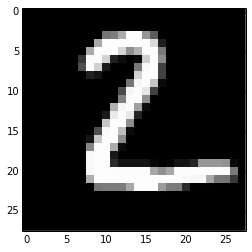

(28, 28)


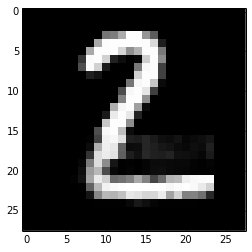

In [11]:
'''
Here the trained network is used to reconstruct a digit.
It is not exactly fair as the network always observes the original 
image to predict the next row, so the reconstruction is almost perfect
'''

sample = mnist.test.next_batch(1)[0]
seq,_ = sequencesFromTrainingData(sample,n_steps)

p = sess.run(pred, feed_dict={x: seq,
                          istate: np.zeros((seq.shape[0], 2*n_hidden))} )

sample = sample[0].reshape(28,28)

plt.imshow(sample, interpolation="none", cmap="gray")
plt.show()



sample[16:, :] = p.reshape(-1,28) 
print sample.shape

plt.imshow(sample, interpolation="none", cmap="gray")

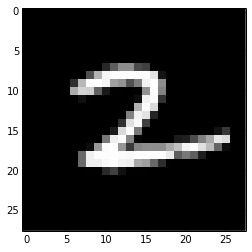

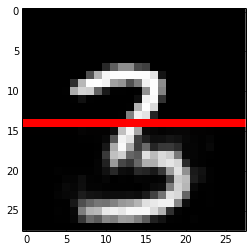

In [20]:
'''
Here the trained network is used to reconstruct a digit in a more difficult way.
The network observes only the #n_steps first rows of the original image 
and then it tries to reconstruct the rest

Note that the window of #n_steps observerd rows moves down as the digit is reconstructed so
each predicted row is considered as part of the input for the next prediction. 
'''

import matplotlib as mpl 

sample = mnist.train.next_batch(1)[0][0].reshape((28,28))
plt.imshow(sample, interpolation="none", cmap="gray")
plt.show()



line = np.zeros((28,28))
line[n_steps, :] = 1
line = np.ma.masked_where(y == 0, y)



for i in range(12):
    
    p = sess.run(pred, feed_dict={x: [sample[i:i+n_steps,:]],
                          istate: np.zeros((1, 2*n_hidden))} )
    sample[i+n_steps] = p

sampleRGB = np.zeros((28,28,3))   

sampleRGB[:,:,0] = sample
sampleRGB[:,:,1] = sample
sampleRGB[:,:,2] = sample

sampleRGB[14,:,:] = 0
sampleRGB[14,:,0] = 1
    
# The red line divides the observed part from the reconstructed part.
# Note that sometimes the net can not identify the digit correctly 
# but it draws a consistent digit anyway    
    
plt.imshow(sampleRGB, interpolation="none")
